<a href="https://colab.research.google.com/github/alexjochs/ECE_539_Penguins/blob/model/Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import h5py
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm as c
import tensorflow as tf
from keras.models import model_from_json
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import load_img,img_to_array
from sklearn.metrics import mean_squared_error
from keras.initializers import RandomNormal
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from keras.models import Model,Sequential
from keras.layers import *
from keras import backend as K
from keras.models import model_from_json
from matplotlib import cm as CM
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import scipy.io as io
from PIL import Image
import PIL
import h5py
import os
import glob
import cv2
import random
import math
import sys
import numpy as np
import json

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def create_img(path):
    #Function to load,normalize and return image 
    im = Image.open(path).convert('RGB')
    im = im.resize((800, 600), Image.ANTIALIAS)

    im = np.array(im)
    
    # im = im/255.0
    
    # im[:,:,0]=(im[:,:,0]-0.485)/0.229
    # im[:,:,1]=(im[:,:,1]-0.456)/0.224
    # im[:,:,2]=(im[:,:,2]-0.406)/0.225
    image = tf.image.convert_image_dtype(im, tf.float32)
    new_image = tf.image.per_image_standardization(image)
    new_image = tf.clip_by_value(new_image, 0.0, 1.0)

    images_list = []
    images_list.append(np.array(new_image))
    x = np.asarray(images_list)

    # print(im.shape)
    #im = np.expand_dims(im,axis  = 0)
    return x

def get_output(path):
    #import target
    #resize target
    
    gt_file = h5py.File(path,'r')
    
    target = np.asarray(gt_file['density'])
    
    # img = cv2.resize(target,(int(target.shape[1]/8),int(target.shape[0]/8)),interpolation = cv2.INTER_CUBIC)*64
    
    # img = np.expand_dims(img, axis=img.ndim)
    
    # print(img.shape)
    
    return target.sum()

In [4]:
root = r'/content'
gdrive_data_filepath = r"/content/drive/MyDrive/Penguin_counting/data_peng_watch"

def get_new_batch(target=None):
    assert target is not None, f"can't get specific folder: {target} and load all data"
    tgz_name = target + '.tgz'
    folder_path = os.path.join(gdrive_data_filepath, tgz_name)
    !tar -xzf {folder_path} -C {root}

In [5]:
with open('/content/drive/MyDrive/Penguin_counting/train_test_data.json', 'r') as f:
  data = json.loads(json.load(f))

train_data = data['train']
test_data = data['test']

get_new_batch('BAILa')
get_new_batch("BAILa_gt")

tar: Removing leading `/' from member names
tar: Removing leading `/' from member names


In [6]:
def my_leaky_relu(x):
    return tf.nn.leaky_relu(x, alpha=0.01)

# Neural network model : VGG + Conv
def CrowdNet():  
            #Variable Input Size
            rows = 600
            cols = 800
            
            #Batch Normalisation option
            
            batch_norm = 1
            kernel = (3, 3)
            init = RandomNormal(stddev=0.01)
            model = Sequential() 
            
            #custom VGG:
            
            if(batch_norm):
                model.add(Conv2D(64, kernel_size = kernel, input_shape = (rows,cols,3),activation = my_leaky_relu, padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(64, kernel_size = kernel,activation = my_leaky_relu, padding='same'))
                model.add(BatchNormalization())
                model.add(MaxPooling2D(strides=2))
                model.add(Conv2D(128,kernel_size = kernel, activation = my_leaky_relu, padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(128,kernel_size = kernel, activation = my_leaky_relu, padding='same'))
                model.add(BatchNormalization())
                model.add(MaxPooling2D(strides=2))
                model.add(Conv2D(256,kernel_size = kernel, activation = my_leaky_relu, padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(256,kernel_size = kernel, activation = my_leaky_relu, padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(256,kernel_size = kernel, activation = my_leaky_relu, padding='same'))
                model.add(BatchNormalization())
                model.add(MaxPooling2D(strides=2))            
                model.add(Conv2D(512, kernel_size = kernel,activation = my_leaky_relu, padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(512, kernel_size = kernel,activation = my_leaky_relu, padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(512, kernel_size = kernel,activation = my_leaky_relu, padding='same'))
                model.add(BatchNormalization())
                
            else:
                model.add(Conv2D(64, kernel_size = kernel,activation = my_leaky_relu, padding='same',input_shape = (rows, cols, 3), kernel_initializer = init))
                model.add(Conv2D(64, kernel_size = kernel,activation = my_leaky_relu, padding='same', kernel_initializer = init))
                model.add(MaxPooling2D(strides=2))
                model.add(Conv2D(128,kernel_size = kernel, activation = my_leaky_relu, padding='same', kernel_initializer = init))
                model.add(Conv2D(128,kernel_size = kernel, activation = my_leaky_relu, padding='same', kernel_initializer = init))
                model.add(MaxPooling2D(strides=2))
                model.add(Conv2D(256,kernel_size = kernel, activation = my_leaky_relu, padding='same', kernel_initializer = init))
                model.add(Conv2D(256,kernel_size = kernel, activation = my_leaky_relu, padding='same', kernel_initializer = init))
                model.add(Conv2D(256,kernel_size = kernel, activation = my_leaky_relu, padding='same', kernel_initializer = init))
                model.add(MaxPooling2D(strides=2))            
                model.add(Conv2D(512, kernel_size = kernel,activation = my_leaky_relu, padding='same', kernel_initializer = init))
                model.add(Conv2D(512, kernel_size = kernel,activation = my_leaky_relu, padding='same', kernel_initializer = init))
                model.add(Conv2D(512, kernel_size = kernel,activation = my_leaky_relu, padding='same', kernel_initializer = init))
                
                

                
            #Conv2D
            model.add(Conv2D(512, (3, 3), activation=my_leaky_relu, dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(512, (3, 3), activation=my_leaky_relu, dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(512, (3, 3), activation=my_leaky_relu, dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(256, (3, 3), activation=my_leaky_relu, dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(128, (3, 3), activation=my_leaky_relu, dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(64, (3, 3), activation=my_leaky_relu, dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(1, (1, 1), activation=my_leaky_relu, dilation_rate = 1, kernel_initializer = init, padding = 'same'))
        
            # sgd = SGD(learning_rate = 1e-6, decay = (5*1e-4), momentum = 0.95)
            opt = Adam(learning_rate=3e-5)
            model.compile(optimizer=opt, loss=euclidean_distance_loss, metrics=['mse', 'mae'])
            
            model = init_weights_vgg(model)
            
            return model

def euclidean_distance_loss(y_true, y_pred):
    # print(y_true.shape, y_pred.shape)
    # Euclidean distance as a measure of loss (Loss function) 
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

def init_weights_vgg(model):
    vgg =  VGG16(weights='imagenet', include_top=False)
    
    # json_file = open('models/VGG_16.json', 'r')
    # loaded_model_json = json_file.read()
    # json_file.close()
    # loaded_model = model_from_json(loaded_model_json)
    # loaded_model.load_weights("weights/VGG_16.h5")
    
    # vgg = loaded_model
    
    vgg_weights=[]                         
    for layer in vgg.layers:
        if('conv' in layer.name):
            vgg_weights.append(layer.get_weights())
    
    
    offset=0
    i=0
    while(i<10):
        if('conv' in model.layers[i+offset].name):
            model.layers[i+offset].set_weights(vgg_weights[i])
            i=i+1
            #print('h')
            
        else:
            offset=offset+1

    return (model)

def get_output(path):
    #import target
    #resize target
    
    gt_file = h5py.File(path,'r')
    
    target = np.asarray(gt_file['density'])
    
    # img = cv2.resize(target,(int(target.shape[1]/8),int(target.shape[0]/8)),interpolation = cv2.INTER_CUBIC)*64
    
    # img = np.expand_dims(img, axis=img.ndim)
    
    # print(img.shape)
    
    return target


Inference and data analysis for baseline model:

In [7]:
model_baseline = CrowdNet()
model_baseline.load_weights("/content/drive/MyDrive/Penguin_counting/model_weights/cp.ckpt")

58900480/58889256 [==============================] - 0s 0us/step


inference and data analysis for fine tuned model:

In [25]:
def predict(path):
    #Function to load image,predict heat map, generate count and return (count , image , heat map)
    image = create_img(path)
    print(image.shape)
    ans = ft_model(image)
    count = np.sum(ans)
    return count,image,ans

In [73]:
print(test_data[i])

/content/content/BAILa/BAILa2014a_000850.JPG


In [68]:
ans,img,hmap = predict(test_data[3])

(1, 600, 800, 3)


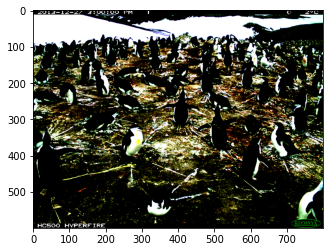

In [69]:
plt.imshow(img.reshape(600,800,3))

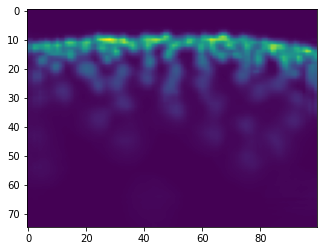

In [70]:
plt.imshow(np.array(hmap).reshape(75,100))

In [71]:
print(ans)

100.83368


In [72]:
output = get_output(test_data[3][:22] + '_gt' + test_data[3][22:].replace('.JPG','_gt.h5'))
print(output.sum())

30.403843


ValueError: ignored

In [24]:
ft_model = CrowdNet()
ft_model.load_weights("/content/drive/MyDrive/Penguin_counting/model_weights/model_ft/cp.ckpt")

In [ ]:
temp = h5py.File('ShanghaiTech/part_A/test_data/ground_truth/IMG_170.h5' , 'r')
temp_1 = np.asarray(temp['density'])
#plt.imshow(temp_1,cmap = c.jet)
print("Original Count : ",int(np.sum(temp_1)) + 1)

Original Count :  662


for each image, get prediction, get gt, add both to seperate lists

In [26]:
i = 0
list_of_pred_vals = []
list_of_gt_vals = []
for img in test_data:
    ans,_,_ = predict(img)
    
    out_path = img[:22] + '_gt' + img[22:].replace('.JPG','_gt.h5')
    output = get_output(out_path)
    if abs(ans-output.sum()) > 20:
        continue
    else:
        list_of_pred_vals.append(ans)
        list_of_gt_vals.append(output.sum())

(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 3)
(1, 600, 800, 

In [28]:
print(len(list_of_pred_vals))

103


In [19]:
print(list_of_gt_vals)

[22.79444, 29.286066, 22.640081, 118.56539, 30.150717, 35.29992, 28.388006, 111.03991, 84.53174, 1.9743959, 73.557594, 39.470512, 76.91126, 44.953712, 3.2259753, 16.619274, 99.17211, 86.78242, 22.665949, 89.493546, 13.554441, 50.478546, 96.04813, 61.095226, 26.154219, 85.72322, 124.263756, 6.144424, 97.83304, 56.761055, 122.07185, 115.117615, 28.824217, 116.546646, 1.2866713, 111.68638, 87.790535, 61.113384, 71.5719, 116.73564, 100.10658, 78.995445, 28.606237, 39.825306, 11.781283, 10.445738, 78.50008, 50.64004, 104.843285, 44.132133, 87.900345, 0.4966502, 20.418184, 59.45338, 13.882563, 132.77647, 34.766323, 55.285797, 119.90965, 23.616777, 19.580349, 105.6851, 25.50183, 24.309387, 44.06648, 116.8967, 99.9679, 15.833061, 0.42120227, 64.361145, 80.19611, 91.29758, 77.90008, 106.332726, 39.583992, 31.424162, 68.86234, 7.7204003, 89.44735, 112.467316, 0.6068413, 108.92427, 6.474277, 96.21116, 37.54578, 99.61467, 95.035904, 59.815975, 28.404413, 2.1744757, 63.008053, 6.731705, 85.39742, 8

In [29]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(list_of_gt_vals, list_of_pred_vals)
print(mse)

91.618904


In [60]:
# manually
se = np.array(list_of_gt_vals) - np.array(list_of_pred_vals)
print(se)
se2 = se ** 2
print(se2)

[ 29.155014  -72.61309    -2.8000374 -70.42984  ]
[ 850.01483   5272.661        7.8402095 4960.3623   ]


In [62]:
print(se2.sum() / 4)

2772.7197265625
